In [210]:
import numpy as np
import numba as nb
from numba import njit, prange
from numba.typed import List
from tqdm.notebook import tqdm, trange
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [2]:
%matplotlib notebook

$$\dot{S} = -\beta S Z $$ 
$$\dot{Z} = (\beta - \kappa) S Z $$
$$\dot{R} = \kappa S Z $$


$$\alpha = \kappa / \beta$$

In [3]:
@njit
def SZR_dot(S, Z, R, b, k):
    return np.array([-b*S*Z, (b-k)*S*Z, k*S*Z])

b = 1
k = 0.6

S_0 = 199
Z_0 = 1
R_0 = 0

SZR = np.array([[S_0, Z_0, R_0]])

dt = 0.0001

for i in range(2000):
    
    SZR = np.append(SZR, [SZR[-1,:] + SZR_dot(SZR[-1,0],SZR[-1,1], SZR[-1,2], b, k)*dt], axis = 0)

<IPython.core.display.Javascript object>


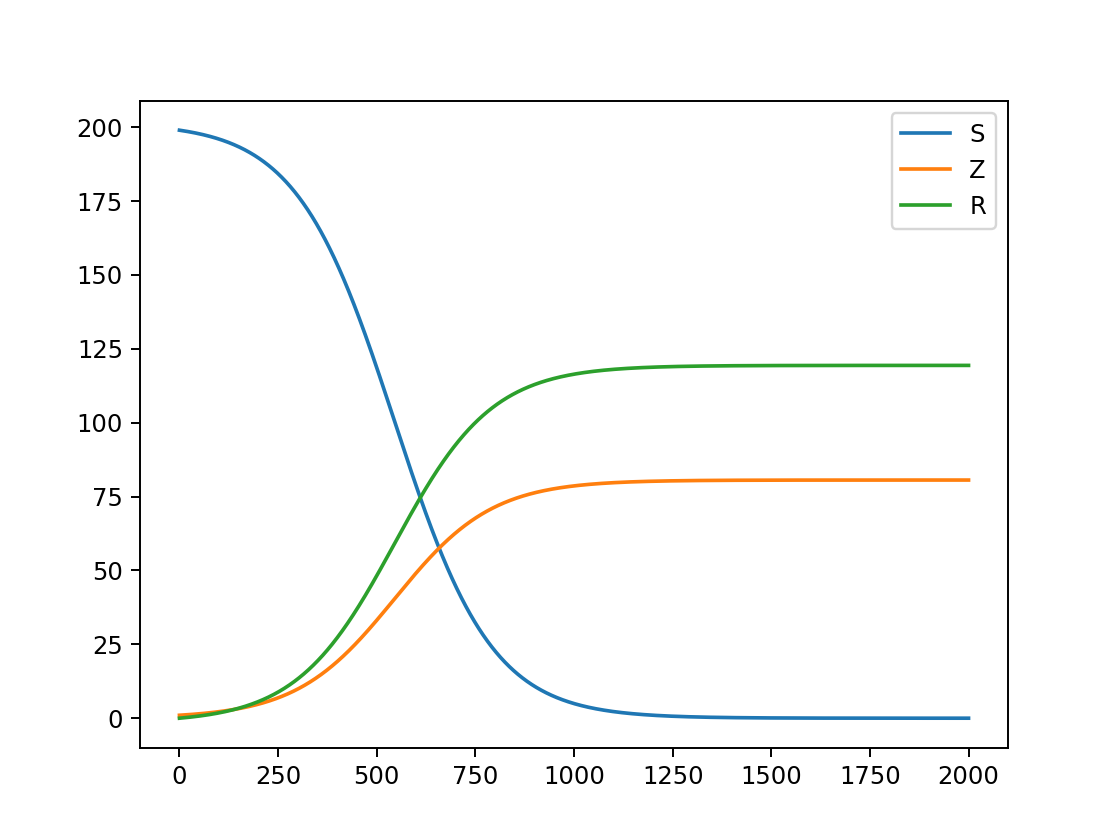

In [4]:
plt.plot(SZR[:,0], label = "S")
plt.plot(SZR[:,1], label = "Z")
plt.plot(SZR[:,2], label = "R")
plt.legend()

Gillespie algorithm

$$p(\tau, j| \vec{x}, t) = a_{j}(\vec{x}) e^{-\tau \Sigma_{j}a_{j}(\vec{x})}$$\\

$$\tau = \frac{1}{\Sigma_{j}a_{j}(\vec{x})}log(\frac{1}{r_{1}})$$

In [16]:
@njit

def get_tau(S:int, Z:int, R:int, b:float, k:float):
    #r1 = 1- np.random.exponential()
    a1 = b*S*Z
    a2 = k*S*Z
    
    return np.random.exponential(1/(a1 + a2)) #1/(a1 + a2) * np.log(1/r1)


def get_j(S:int, Z:int, R:int, b:float, k:float):
    r2 = np.random.uniform(0,1)
    if r2 <  b/(b + k):
        return 0
    else:
        return 1
    
    
def update(S:int, Z:int, R:int, t:float, b:float, k:float):
    tau = get_tau(S, Z, R, b, k)
    t_new = t + tau
    if get_j(S, Z, R, b, k) == 0:
        S_new = S - 1
        Z_new = Z + 1
        R_new = R
    else:
        S_new = S
        Z_new = Z - 1
        R_new = R + 1
        
    return S_new, Z_new, R_new, t_new

In [17]:
@njit
def nb_seed(seed):
    np.random.seed(seed)

In [18]:
nb_seed(123456)

In [44]:
S_0 = 199
Z_0 = 1
R_0 = 0

SZR = np.array([[S_0, Z_0, R_0]])

b = 1
k = 0.6
t = [0]

for i in range(4000):
    
    S_n, Z_n, R_n, t_n = update(SZR[-1, 0], SZR[-1, 1], SZR[-1, 2], t[-1], b, k)
    
    SZR = np.append(SZR, [[S_n, Z_n, R_n]], axis = 0)
    t.append(t_n)
    
    if S_n == 0 or Z_n == 0:
        break

<IPython.core.display.Javascript object>


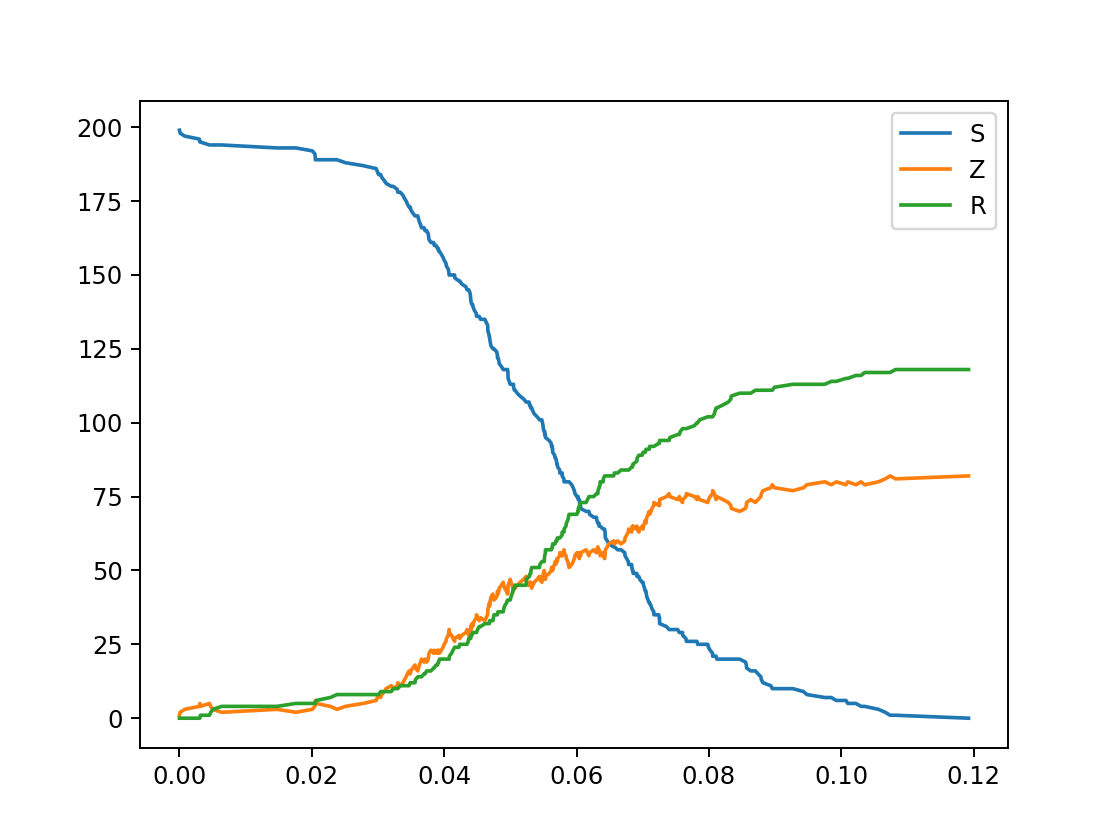

In [45]:
plt.plot(t, SZR[:,0], label = "S")
plt.plot(t, SZR[:,1], label = "Z")
plt.plot(t, SZR[:,2], label = "R")
plt.legend()

square lattice model

In [191]:
np.where?

In [239]:
@njit
def check(lattice:np.ndarray, queue):
    
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    
    counter = 0
    
    xz, yz = np.where(lattice == 1)
    zlist = List()
    
    for i in range(len(xz)):
        zlist.append((xz[i], yz[i]))
    #zlist = np.transpose(np.array(np.where(lattice == 1)))
    
    for xyz in zlist:

        for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
            if lattice[xyn] == 0:
                counter = counter + 1
                if (xyz, xyn) not in queue:
                    print(xyz, xyn)
                    return False
                
    if counter == len(queue):
        return True
    else:
        print(counter, len(queue))
        return False
    

def update(lattice:np.ndarray, queue, k:float, b:float):
    
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    
    if len(queue) == 0:
        return lattice, queue
    
    ind = np.random.randint(len(queue))
    r = np.random.uniform()
    
    if r < b/(b + k):
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xys] = 1
        
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] == 0:
                queue.append((xys, xyn))
                
        
        if len(queue) == 0:
            return lattice, queue
        
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] == 1 and xyn != xyz:
                queue.remove((xyn, xys))
 
        

    else:
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xyz] = 2
        
        if len(queue) == 0:
            return lattice, queue
        
        for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
            if lattice[xyn] == 0 and xyn != xys:
                queue.remove((xyz, xyn))
               
    
    return lattice, queue




def init_lattice(L:int, xy0):
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    
    lattice = np.zeros((L, L), dtype = int)
    lattice[xy0] = 1
    queue = [(xy0,  left(xy0)), 
             (xy0, right(xy0)), 
             (xy0,    up(xy0)), 
             (xy0,  down(xy0))]
    
    return lattice, queue

def run_lattice(L:int, xy0, k:float, b:float):
    
    lattice, queue = init_lattice(L, xy0)
    counter = 0    
    start_time = time.time()
    while len(queue) != 0:
        counter = counter + 1
        lattice, queue = update(lattice, queue, k, b)
        
#        if counter%100 == 0:
#            print(str(counter) + ":" + str(time.time() - start_time))
            
    return lattice, queue, time.time() - start_time



    
def run_check_lattice(L:int, xy0, k:float, b:float):
    
    lattice, queue = init_lattice(L, xy0)
    counter = 0
    start_time = time.time()
    while len(queue) != 0:
        
        if check(lattice, queue) == False:
            print("error")
            break
           
        counter = counter + 1
        lattice, queue = update(lattice, queue, k, b)
        
#        if counter%100 == 0:
#            print(str(counter) + ":" + str(time.time() - start_time))
        
    return lattice, queue, time.time() - start_time

In [240]:
seed

889271

<IPython.core.display.Javascript object>


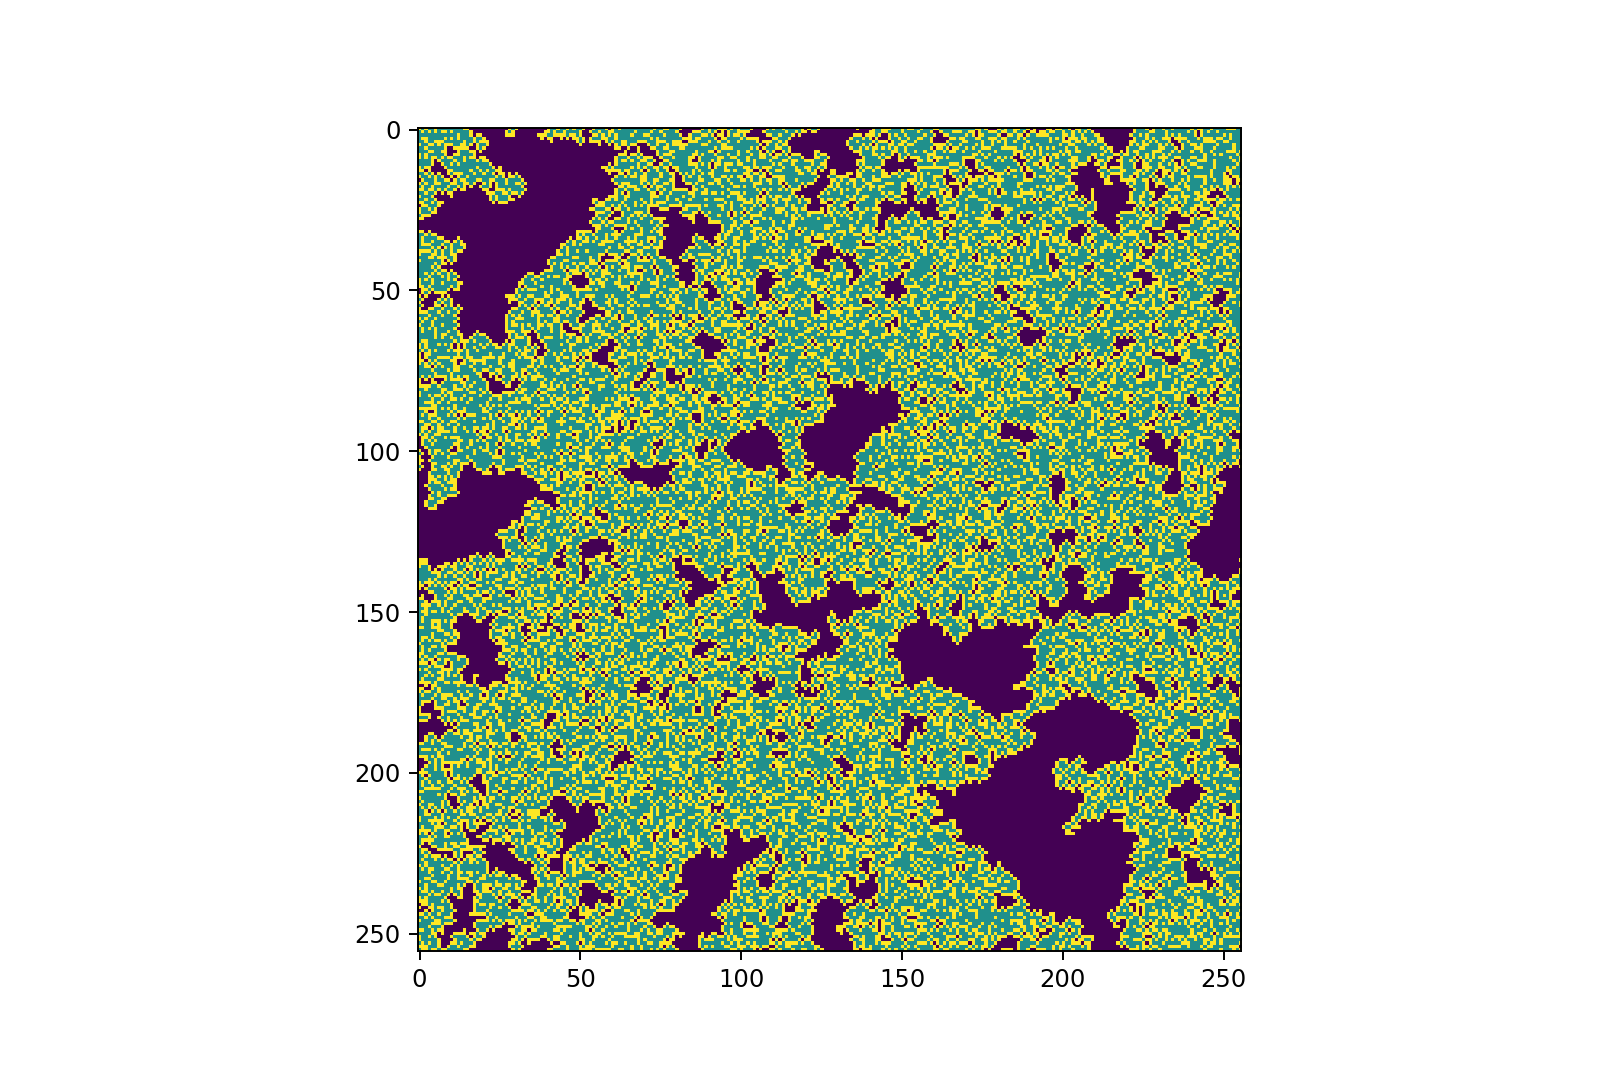

0.7860009670257568


In [241]:
seed = np.random.randint(1000000)
np.random.seed(920217) 
lattice, queue, timeit = run_lattice(256, (0, 0), 0.43, 1)
plt.imshow(lattice)
print(timeit)

In [237]:
seed

206939

<IPython.core.display.Javascript object>


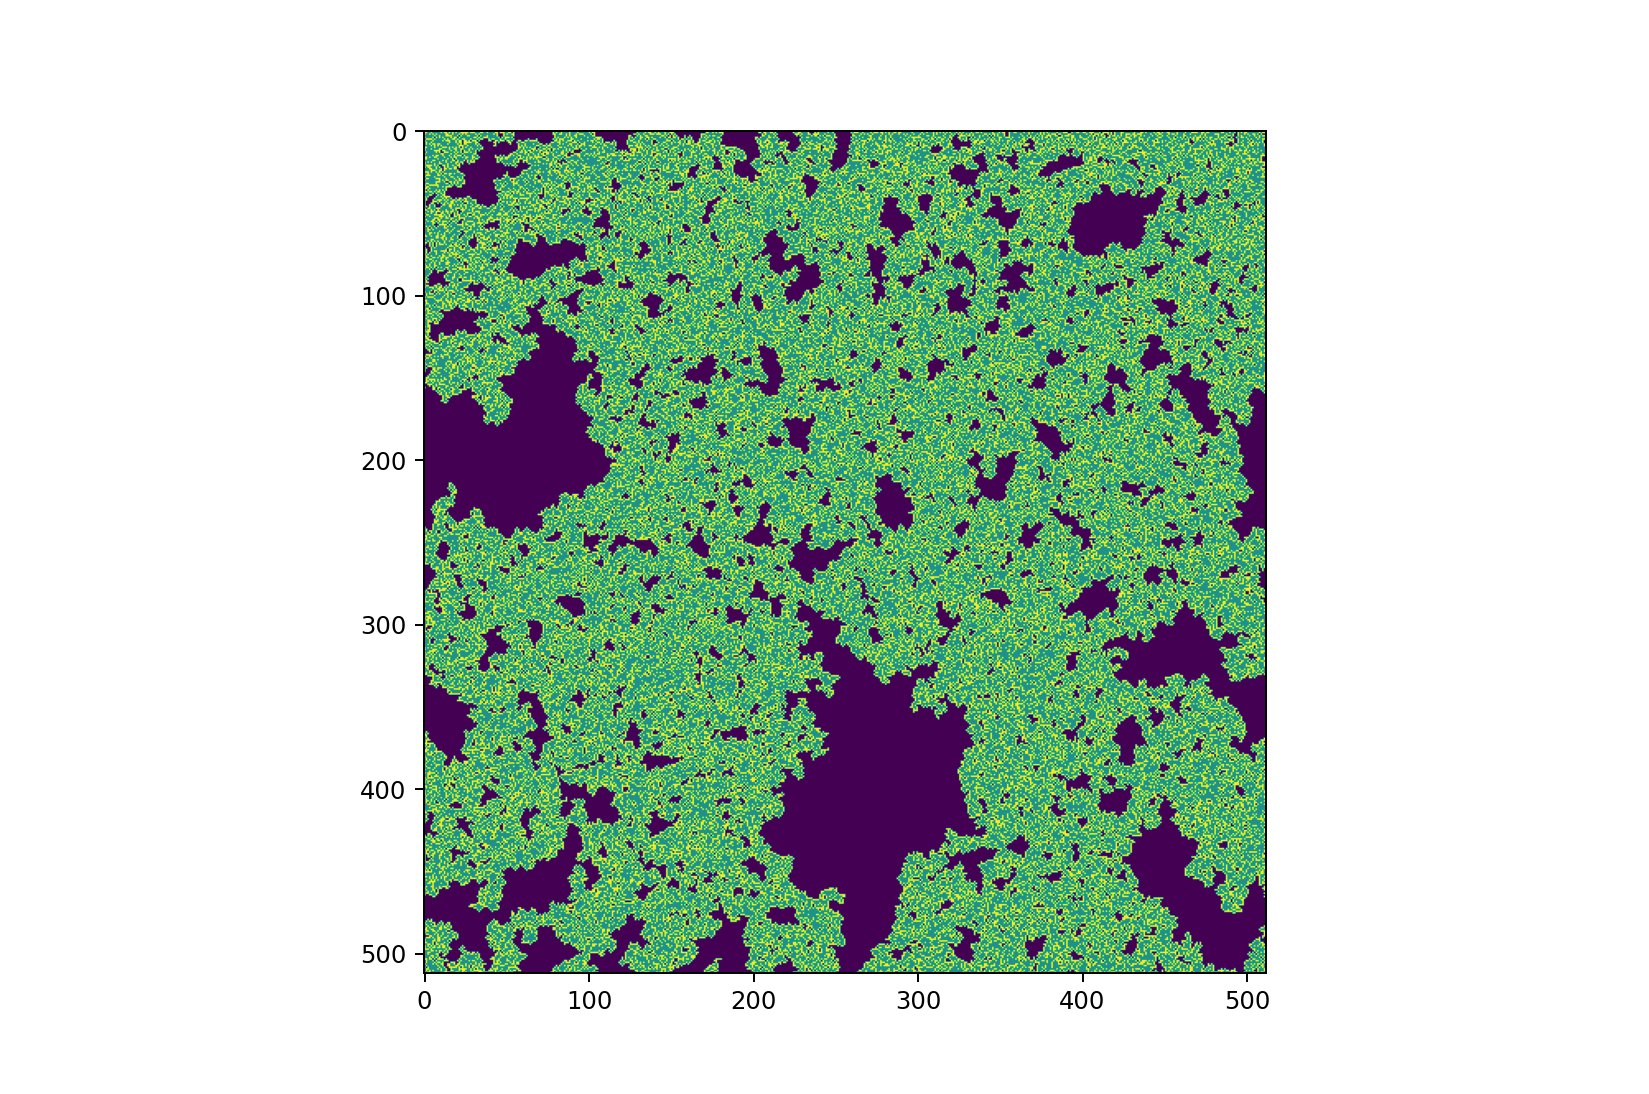

3.5815815925598145


In [243]:
seed = np.random.randint(1000000)
np.random.seed(seed) 
lattice, queue, timeit = run_lattice(512, (256, 256), 0.43, 1)
plt.imshow(lattice)
print(timeit)

<IPython.core.display.Javascript object>


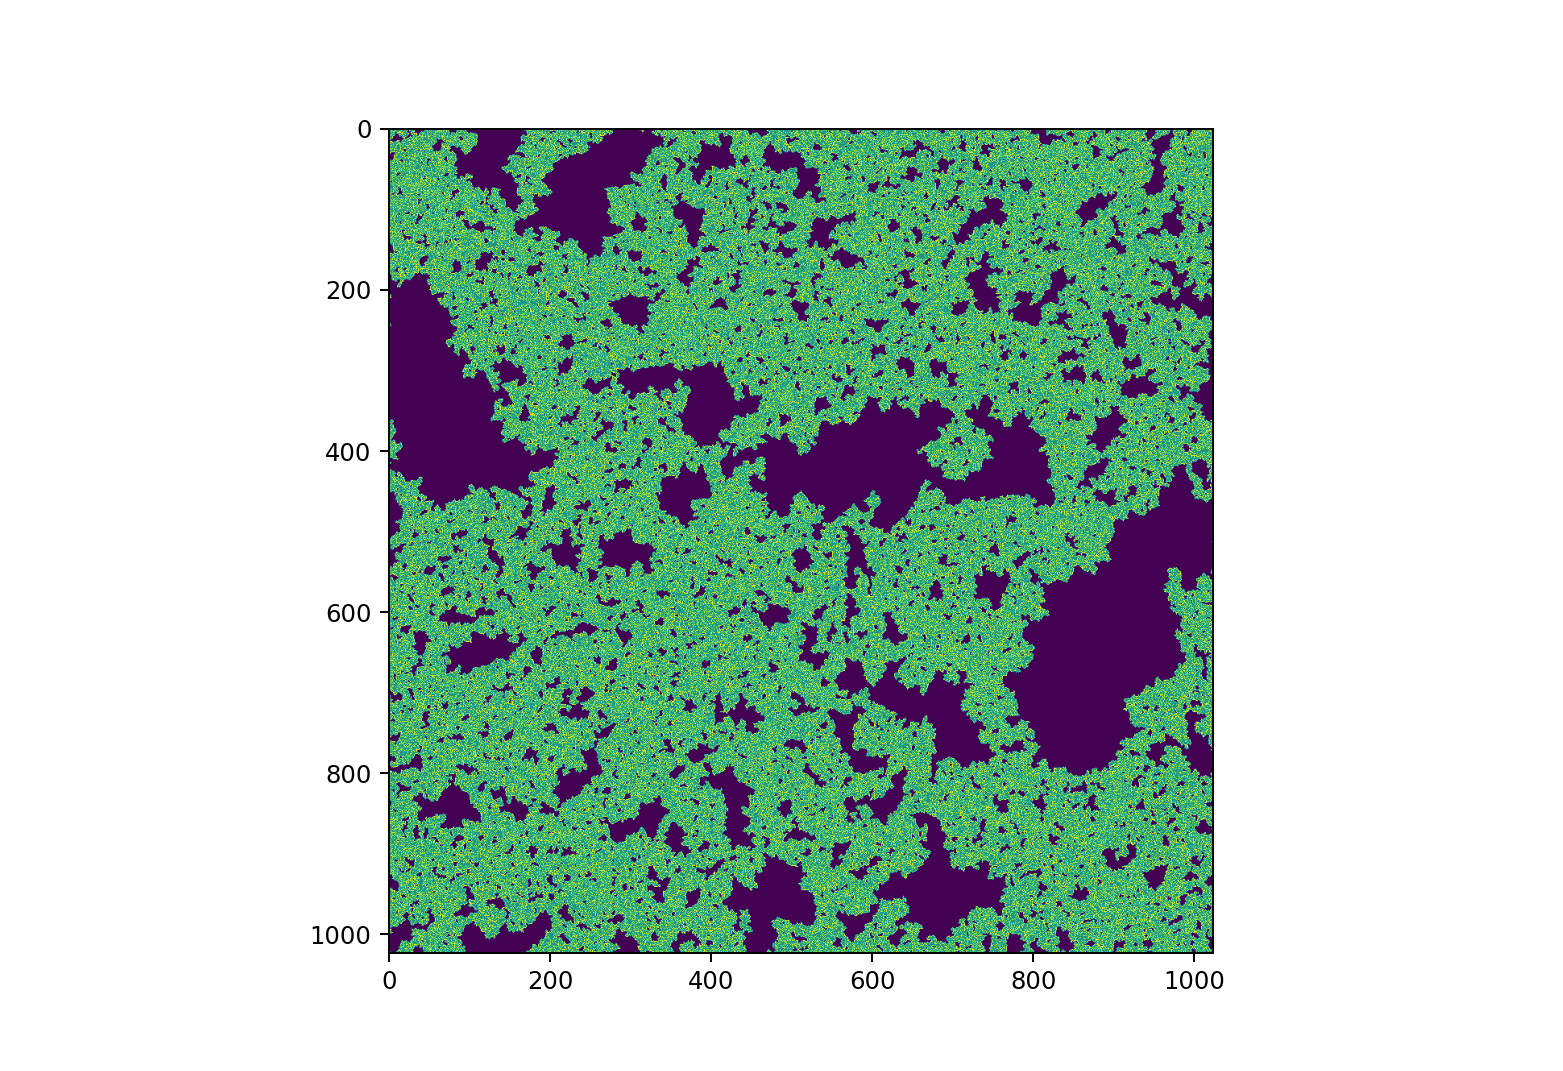

14.72169017791748


In [245]:
seed = np.random.randint(1000000)
np.random.seed(206939) 
lattice, queue, timeit = run_lattice(1024, (512, 512), 0.43734613, 1)
plt.imshow(lattice)
print(timeit)

<IPython.core.display.Javascript object>


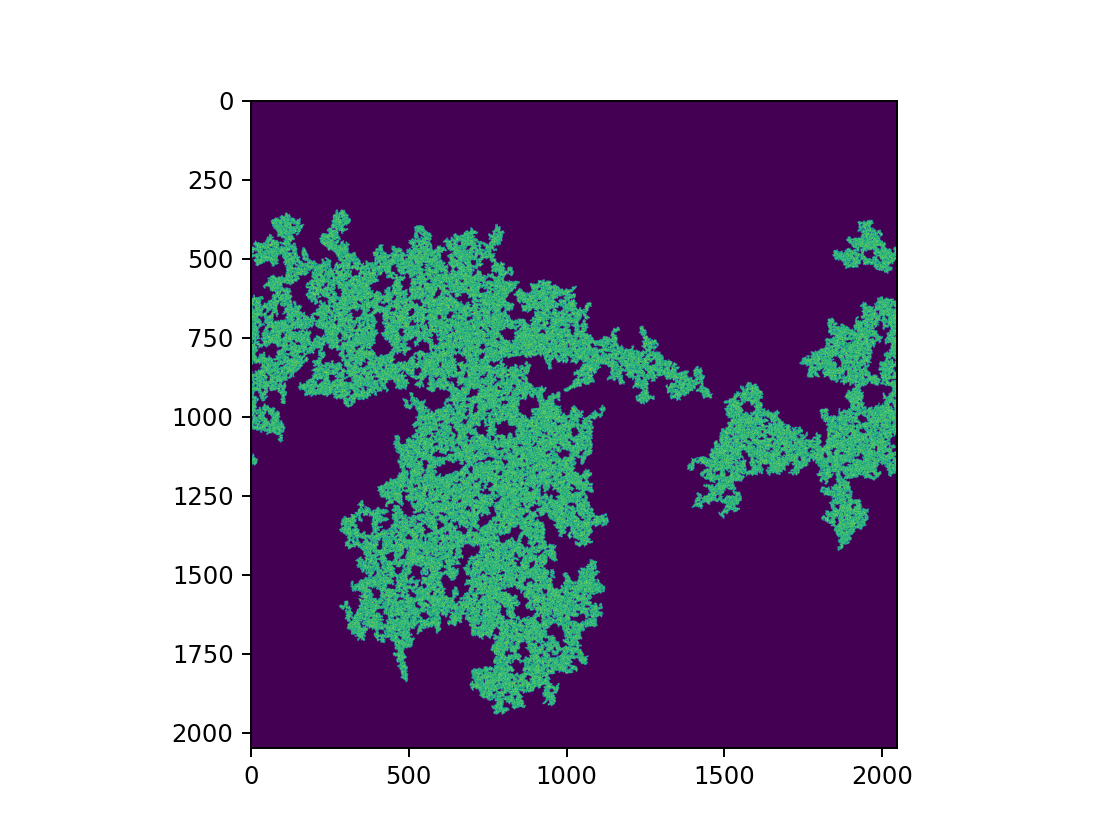

22.306994676589966


In [246]:
seed = np.random.randint(1000000)
np.random.seed(206939) 
lattice, queue, timeit = run_lattice(2048, (1024, 1024), 0.43734613, 1)
plt.imshow(lattice)
print(timeit)

<IPython.core.display.Javascript object>


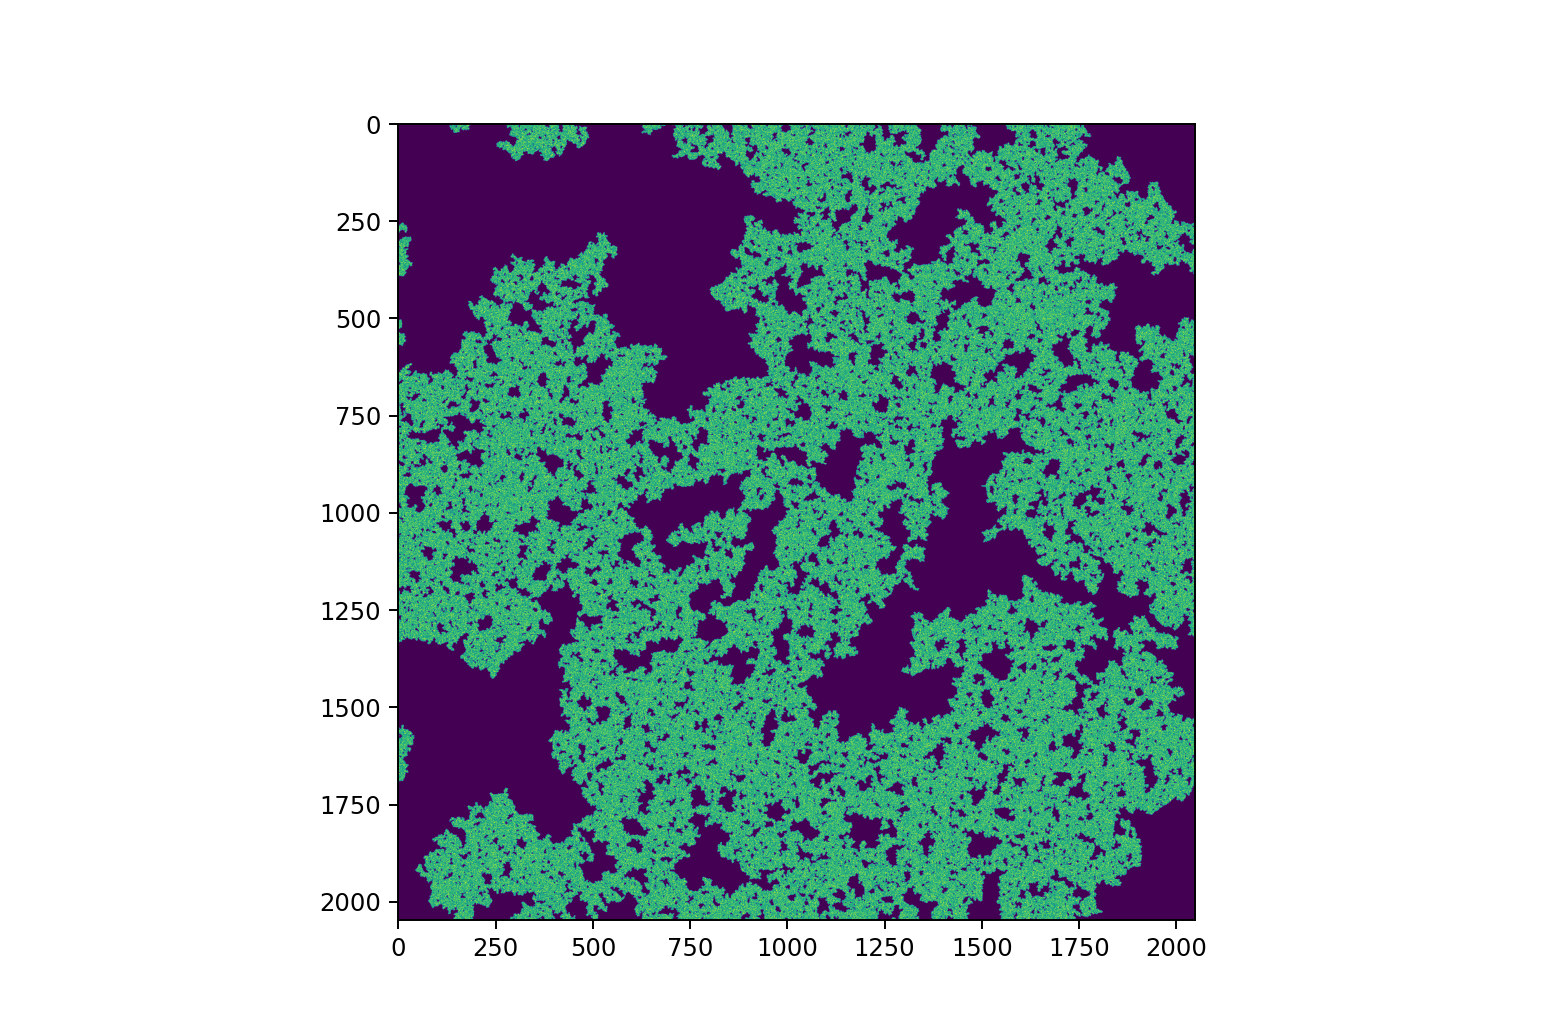

60.26720881462097


In [253]:
seed = np.random.randint(1000000)
np.random.seed(seed) 
lattice, queue, timeit = run_lattice(2048, (1024, 1024), 0.4373461357, 1)
plt.imshow(lattice)
print(timeit)

In [254]:
seed

524149